In [2]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

2024-11-29 10:46:28.120778: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 10:46:28.125100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 10:46:28.170685: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 10:46:28.218951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732873588.267498   10103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732873588.28

In [3]:
@tf.py_function(Tout=float)
def rgb2lab_tensor(img):
    img_numpy = img.numpy()
    img_numpy /= 255 # TODO : bouger la normalisation ailleurs
    img_lab = skimage.color.rgb2lab(img_numpy)
    return  tf.convert_to_tensor(img_lab)

In [4]:
train, test = keras.utils.image_dataset_from_directory(
    "my_celebs",
    labels=None,
    validation_split=0.2,
    subset="both",
    seed=1,
    image_size=(128, 128),
)

Found 33062 files.
Using 26450 files for training.
Using 6612 files for validation.


2024-11-29 10:46:31.073534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
def preparer_dataset(dataset):
    batch_size = 32
    dataset_lab = dataset.unbatch().map(rgb2lab_tensor).batch(batch_size)
    dataset_separe = dataset_lab.map(lambda x: (tf.ensure_shape(x[:, :, :, 0], [None, 128,128]),
                                                tf.ensure_shape(x[:, :, :, 1:], [None, 128,128,2])))
    return dataset_separe

In [6]:
train_separe = preparer_dataset(train)
test_separe = preparer_dataset(test)

In [7]:
elem = next(iter(train_separe))
elem[0]

<tf.Tensor: shape=(32, 128, 128), dtype=float32, numpy=
array([[[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        ...,
        [ 38.982983  ,  56.11155   ,  69.31203   , ...,  73.84509   ,
          96.03551   ,  98.51557   ],
        [ 40.440533  ,  39.766243  ,  59.905014  , ...,  76.74685   ,
          83.18629   ,  99.29625   ],
        [ 39.098568  ,  38.134922  ,  39.476437  , ...,  51.930634  ,
          74.882645  ,  96.304146  ]],

       [[ 96.35123   ,  96.21912   ,  96.12572   , ...,  99.60557   ,
          99.25889   ,  98.67038   ],
        [ 95.93815   ,  96.11972   ,  96.248     , ...,  99.59748   ,
          98.90543   ,  98.38809   ],
        [ 95.59597   ,  95.70119   ,  95.77551   , ...,  99.59134

In [8]:
reseau = keras.Sequential(
    [
        keras.Input((128, 128)),
        keras.layers.Reshape((128, 128, 1)),
        keras.layers.Rescaling(scale=1./50, offset=-1),
        keras.layers.Conv2D(64,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(1024,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(512,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(256,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(128,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(64,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(2,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="tanh"
                            ),
        keras.layers.Rescaling(scale=128.)
    ]
)


# layers = [keras.layers.Rescaling(scale=1./50, offset=-1)]

# for depth in [64, 128, 256, 512, 1024]:
#     layers.append(keras.layers.Conv2D(depth,
#                             kernel_size=(3,3),
#                             strides=2,
#                             padding="same",
#                             activation="relu"
#                             ),
# )

reseau.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 2)    │         1,154 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,546,370 (47.86 MB)

 Trainable params: 12,542,402 (47.85 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
model = keras.Sequential(
    [
        keras.Input((128, 128)),
        keras.layers.Reshape((128, 128, 1)),
        keras.layers.Rescaling(scale=1./50, offset=-1),
        keras.layers.Conv2D(64,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(1024,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(512,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2DTranspose(256,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2DTranspose(128,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(675,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="sigmoid"
                            ),
    ]
)

model.summary()

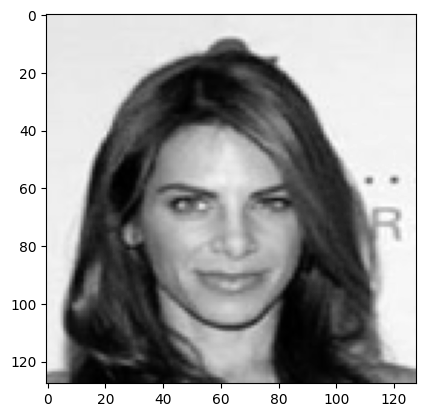

In [9]:
mon_batch = next(iter(train_separe))
ma_celeb_L = mon_batch[0][0]
ma_celeb_ab = mon_batch[1][0]
plt.imshow(ma_celeb_L, cmap="gray")

In [10]:
def rassembler_L_et_ab(L, ab):
    a = ab[:,:,0]
    b = ab[:,:,0]
    return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))

def rassembler_L_et_ab_tensor(L_tensor, ab_tensor):
    L_numpy = L_tensor.numpy()
    ab_numpy = ab_tensor.numpy()
    rgb_numpy = rassembler_L_et_ab(L_numpy, ab_numpy)
    return tf.convert_to_tensor(rgb_numpy)

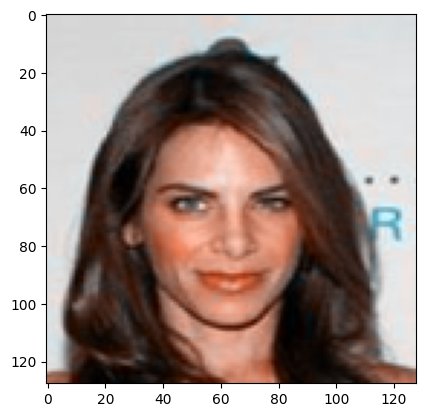

In [11]:
plt.imshow(rassembler_L_et_ab_tensor(ma_celeb_L, ma_celeb_ab))

In [12]:
ma_celeb_ab_predict = reseau.predict(tf.convert_to_tensor([ma_celeb_L]), batch_size =1)[0,:,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [13]:
ma_celeb_ab_predict.shape

(128, 128, 2)

/tmp/ipykernel_10103/2028043554.py:4: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 27 negative Z values that have been clipped to zero
  return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))


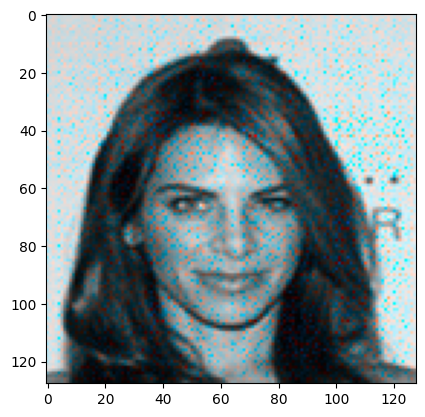

In [14]:
plt.imshow(rassembler_L_et_ab_tensor(ma_celeb_L, tf.convert_to_tensor(ma_celeb_ab_predict*1000)))

In [15]:
reseau.compile(optimizer="adam",
               loss="mse")

reseau.fit(train_separe, epochs=5)

Epoch 1/5
      2/Unknown 4s 561ms/step - loss: 255.9734

KeyboardInterrupt: 